<p style=""></p><p><b style=""><font size="3">infoGAN with Tensorflow</font></b></p><p><font size="2">218012040 魏青</font></p><div><br></div><p></p>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt

/home/yxu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<p style=""></p><p><font size="3"><b>load dataset </b>(the initial four gz files have been transferred into two csv files)</font></p><p></p>

In [2]:
train = pd.read_csv('/home/yxu/QINGQING/mnist_train.csv')
test = pd.read_csv('/home/yxu/QINGQING/mnist_test.csv')
train_data = train.iloc[:, 1:].values
train_label = train.iloc[:, 0].values
train_data = train_data / 127.5 - 1.
train_data = np.reshape(train_data, (-1, 28, 28, 1))

<p style=""></p><p><font size="3"><b>Define infoGAN model&nbsp;</b>(discriminator, generator, cost)</font></p><p></p>

In [3]:
class InfoGan_withoutc:
    def __init__(self):
        self.X=tf.placeholder(dtype=tf.float32,shape=[None,28,28,1])
        self.Z=tf.placeholder(dtype=tf.float32,shape=[None,42])
        self.C=tf.placeholder(dtype=tf.float32,shape=[None,2])
        self.D=tf.placeholder(dtype=tf.float32,shape=[None,10])
        self.is_training_d=tf.placeholder(tf.bool,[])
        self.is_training_g=tf.placeholder(tf.bool,[])
        
    def Discriminator(self,x,reuse):
        with tf.variable_scope('discriminator',reuse=reuse):
            out1=tf.layers.conv2d(x,64,4,2,padding='SAME',kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),name='c_1')
            out1=self.lrelu(out1)
            out2=tf.layers.conv2d(out1,128,4,2,padding='SAME',kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),use_bias=False,name='c_2')
            out2=tf.layers.batch_normalization(out2,training=self.is_training_d,name='n_2')
            out2=self.lrelu(out2)
            out3=tf.reshape(out2,(-1,7*7*128))
            out3=tf.layers.dense(out3,1024,kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),use_bias=False,name='f_3')
            out3=tf.layers.batch_normalization(out3,training=self.is_training_d,name='n_3')
            out3=self.lrelu(out3)
            with tf.variable_scope('Discriminator_output'):
                D_out=tf.layers.dense(out3,1,kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),name='D_out')
                D_out=tf.nn.sigmoid(D_out)
            with tf.variable_scope('latent_code'):
                out4=tf.layers.dense(out3,128,kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),use_bias=False,name='f_4')
                out4=tf.layers.batch_normalization(out4,training=self.is_training_d,name='n_4')
                out4=self.lrelu(out4)
                #mean=tf.layers.dense(out4,2,kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),name='c_mean')
                #log_std=tf.layers.dense(out4,2,kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),name='c_stddev')
                discrete=tf.layers.dense(out4,10,kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),name='discrete')
            #return D_out,discrete,mean,log_std
            return D_out,discrete
                
    def Generator(self,reuse):
        with tf.variable_scope('generator',reuse=reuse):
            latent=tf.concat([self.Z,self.D],1)
            out1=tf.layers.dense(latent,1024,kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),use_bias=False,name='f_1')
            out1=tf.layers.batch_normalization(out1,training=self.is_training_g,name='b_1')
            out1=tf.nn.relu(out1)
            out2=tf.layers.dense(out1,7*7*128,kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),use_bias=False,name='f_2')
            out2=tf.reshape(out2,[-1,7,7,128])
            out2=tf.layers.batch_normalization(out2,training=self.is_training_g,name='b_2')
            out2=tf.nn.relu(out2)
            out3=tf.layers.conv2d_transpose(out2,64,4,2,padding='SAME',kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),use_bias=False,name='dc_3')
            out3=tf.layers.batch_normalization(out3,training=self.is_training_g,name='b_3')
            out3=tf.nn.relu(out3)
            out4=tf.layers.conv2d_transpose(out3,1,4,2,padding='SAME',kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),name='dc_4')
            final=tf.nn.tanh(out4)
            return final
    
    def cost(self):
        #d_true,_,_,_=self.Discriminator(self.X,False)
        d_true,_=self.Discriminator(self.X,False)
        self.fake_image=self.Generator(False)
        #d_gen,discrete,mean,log_std=self.Discriminator(self.fake_image,reuse=True)
        d_gen,discrete=self.Discriminator(self.fake_image,reuse=True)
        D_loss=-tf.reduce_mean(tf.log(d_true))-tf.reduce_mean(tf.log(1.-d_gen))
        G_loss=tf.reduce_mean(-tf.log(d_gen))
        #self.g_c_loss=tf.reduce_mean(tf.reduce_sum(log_std+0.5*tf.square((self.C-mean)/tf.exp(log_std)),reduction_indices=1))
        self.g_d_loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.D,logits=discrete))
        self.mutual_info=self.g_d_loss
        self.g_loss=G_loss
        self.d_loss=D_loss
        
    def lrelu(self,x,leak=0.1):
        return tf.maximum(x,leak*x)

In [4]:
class InfoGan:
    def __init__(self):
        self.X=tf.placeholder(dtype=tf.float32,shape=[None,28,28,1])
        self.Z=tf.placeholder(dtype=tf.float32,shape=[None,62])
        self.C=tf.placeholder(dtype=tf.float32,shape=[None,2])
        self.D=tf.placeholder(dtype=tf.float32,shape=[None,10])
        self.is_training_d=tf.placeholder(tf.bool,[])
        self.is_training_g=tf.placeholder(tf.bool,[])
        
    def Discriminator(self,x,reuse):
        with tf.variable_scope('discriminator',reuse=reuse):
            out1=tf.layers.conv2d(x,64,4,2,padding='SAME',kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),name='c_1')
            out1=self.lrelu(out1)
            out2=tf.layers.conv2d(out1,128,4,2,padding='SAME',kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),use_bias=False,name='c_2')
            out2=tf.layers.batch_normalization(out2,training=self.is_training_d,name='n_2')
            out2=self.lrelu(out2)
            out3=tf.reshape(out2,(-1,7*7*128))
            out3=tf.layers.dense(out3,1024,kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),use_bias=False,name='f_3')
            out3=tf.layers.batch_normalization(out3,training=self.is_training_d,name='n_3')
            out3=self.lrelu(out3)
            with tf.variable_scope('Discriminator_output'):
                D_out=tf.layers.dense(out3,1,kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),name='D_out')
                D_out=tf.nn.sigmoid(D_out)
            with tf.variable_scope('latent_code'):
                out4=tf.layers.dense(out3,128,kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),use_bias=False,name='f_4')
                out4=tf.layers.batch_normalization(out4,training=self.is_training_d,name='n_4')
                out4=self.lrelu(out4)
                mean=tf.layers.dense(out4,2,kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),name='c_mean')
                log_std=tf.layers.dense(out4,2,kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),name='c_stddev')
                discrete=tf.layers.dense(out4,10,kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),name='discrete')
            return D_out,discrete,mean,log_std
                
    def Generator(self,reuse):
        with tf.variable_scope('generator',reuse=reuse):
            latent=tf.concat([self.Z,self.D,self.C],1)
            out1=tf.layers.dense(latent,1024,kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),use_bias=False,name='f_1')
            out1=tf.layers.batch_normalization(out1,training=self.is_training_g,name='b_1')
            out1=tf.nn.relu(out1)
            out2=tf.layers.dense(out1,7*7*128,kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),use_bias=False,name='f_2')
            out2=tf.reshape(out2,[-1,7,7,128])
            out2=tf.layers.batch_normalization(out2,training=self.is_training_g,name='b_2')
            out2=tf.nn.relu(out2)
            out3=tf.layers.conv2d_transpose(out2,64,4,2,padding='SAME',kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),use_bias=False,name='dc_3')
            out3=tf.layers.batch_normalization(out3,training=self.is_training_g,name='b_3')
            out3=tf.nn.relu(out3)
            out4=tf.layers.conv2d_transpose(out3,1,4,2,padding='SAME',kernel_initializer=tf.random_normal_initializer(0,stddev=0.02),name='dc_4')
            final=tf.nn.tanh(out4)
            return final
    
    def cost(self):
        d_true,_,_,_=self.Discriminator(self.X,False)
        self.fake_image=self.Generator(False)
        d_gen,discrete,mean,log_std=self.Discriminator(self.fake_image,reuse=True)
        D_loss=-tf.reduce_mean(tf.log(d_true))-tf.reduce_mean(tf.log(1.-d_gen))
        G_loss=tf.reduce_mean(-tf.log(d_gen))
        self.g_c_loss=tf.reduce_mean(tf.reduce_sum(log_std+0.5*tf.square((self.C-mean)/tf.exp(log_std)),reduction_indices=1))
        self.g_d_loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.D,logits=discrete))
        self.mutual_info=self.g_d_loss+self.g_c_loss
        self.g_loss=G_loss
        self.d_loss=D_loss
        
    def lrelu(self,x,leak=0.1):
        return tf.maximum(x,leak*x)

In [5]:
#generate latent codes
def sample(size):
    z=np.random.uniform(-1,1,size=(size,62))
    c=np.random.uniform(-1,1,size=(size,2))
    d=np.zeros((size,10))
    idx=np.random.randint(0,10,size=size)
    d[np.arange(size),idx]=1
    return z,c,d

In [6]:
#shuffle the training data
def shuffle(x):
    indice=np.random.permutation(len(x))
    return x[indice]

<p style=""></p><p><font size="3"><b>Model training</b></font></p><p></p>

In [7]:
def train(data,batch_size):
    model=InfoGan()
    model.cost()
    var_list=tf.trainable_variables()
    D_var=[var for var in var_list if 'discriminator' in var.name and 'latent_code' not in var.name]
    G_var=[var for var in var_list if 'generator' in var.name]
    m1_var=[var for var in var_list if 'discriminator' in var.name and 'Discriminator_output' not in var.name]
    m_var=m1_var+G_var
    op_d=tf.train.AdamOptimizer(2e-4)
    op_g=tf.train.AdamOptimizer(2e-4)
    op_m=tf.train.AdamOptimizer(2e-4)
    saver=tf.train.Saver(tf.global_variables())
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        op_D=op_d.minimize(model.d_loss,var_list=D_var)
        op_G=op_g.minimize(model.g_loss,var_list=G_var)
        op_M=op_m.minimize(model.mutual_info,var_list=m_var)
    step=len(data)//batch_size
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(20):
            x=shuffle(data)
            for j in range(step):
                z,c,d=sample(batch_size)
                _,curr_dloss=sess.run([op_D,model.d_loss],feed_dict={model.X:x[j*batch_size:(j+1)*batch_size],model.Z:z,model.C:c,model.D:d,model.is_training_d:True,model.is_training_g:True})
                z,c,d=sample(batch_size)
                _,curr_gloss,curr_image=sess.run([op_G,model.g_loss,model.fake_image],feed_dict={model.X:x[j*batch_size:(j+1)*batch_size],model.Z:z,model.C:c,model.D:d,model.is_training_d:True,model.is_training_g:True})
                z,c,d=sample(batch_size)
                _,curr_mloss,curr_closs,curr_dloss=sess.run([op_M,model.mutual_info,model.g_c_loss,model.g_d_loss],feed_dict={model.X:x[j*batch_size:(j+1)*batch_size],model.Z:z,model.C:c,model.D:d,model.is_training_d:True,model.is_training_g:True})
                if j%1000==0:
                    print('### Epoch {}, Step {} ###'.format(i,j))
                    print('Current D_loss: {}, Current G_loss: {}, current_mutual: {}, current c loss: {}, curr d loss: {}\n'.format(curr_dloss,curr_gloss,curr_mloss,curr_closs,curr_dloss))
                    #print('Current D_loss: {}, Current G_loss: {}, current_mutual: {}\n'.format(curr_dloss,curr_gloss,curr_mloss))
                if j%10000==0:
                    canvas=np.empty((28*10,28*10))
                    for xi in range(10):
                        for yi in range(10):
                            canvas[(xi)*28:(xi+1)*28,yi*28:(yi+1)*28]=curr_image[xi*10+yi].reshape(28,28)
                    plt.figure(figsize=(8,10))
                    plt.imshow(canvas,origin='upper',cmap='gray')
                    plt.title('latent space to generate images')
                    plt.tight_layout()  
                    plt.show()
        saver.save(sess,os.path.join(os.getcwd(),'InfoGan_model/InfoGan_4.ckpt'))

<p style=""></p><p><font size="3"><b>Train the model with batch size 100 for 20 epoches</b></font></p><p></p>

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

### Epoch 0, Step 0 ###
Current D_loss: 2.312190294265747, Current G_loss: 0.7783281803131104, current_mutual: 2.6936752796173096, current c loss: 0.3814850151538849, curr d loss: 2.312190294265747



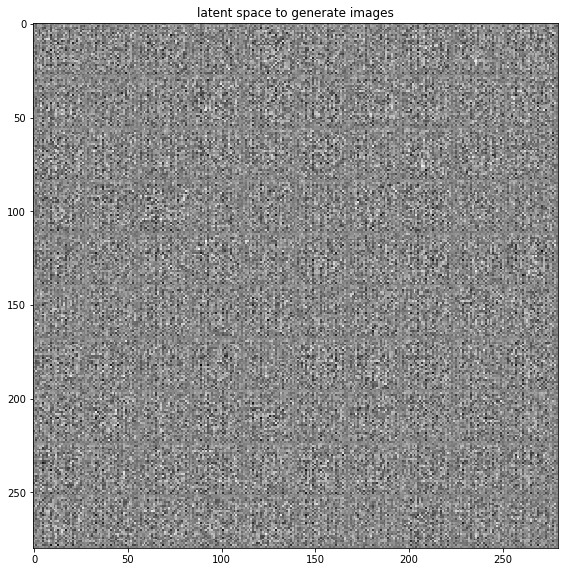

### Epoch 1, Step 0 ###
Current D_loss: 0.34053435921669006, Current G_loss: 1.8806527853012085, current_mutual: -0.8749752044677734, current c loss: -1.2155095338821411, curr d loss: 0.34053435921669006



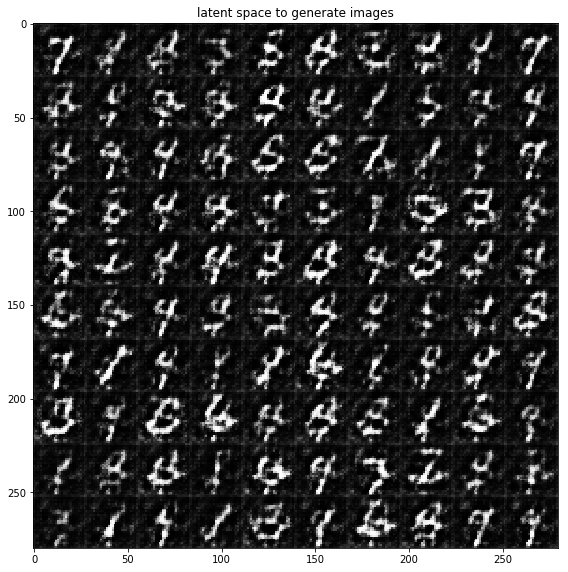

### Epoch 2, Step 0 ###
Current D_loss: 0.13487176597118378, Current G_loss: 1.461096167564392, current_mutual: -2.6808173656463623, current c loss: -2.8156890869140625, curr d loss: 0.13487176597118378



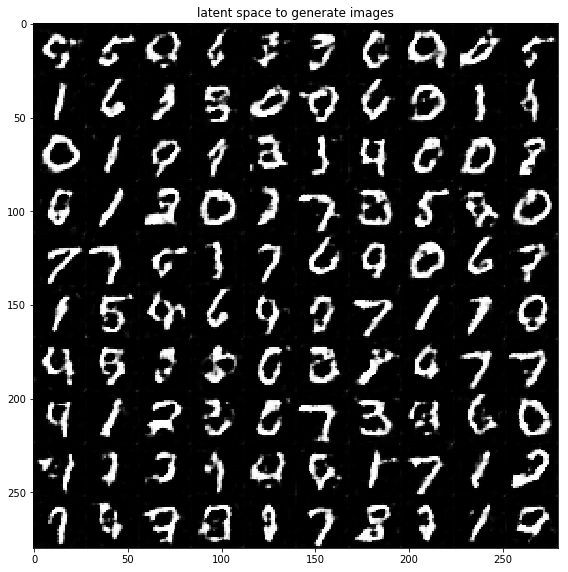

### Epoch 3, Step 0 ###
Current D_loss: 0.14749754965305328, Current G_loss: 1.5034390687942505, current_mutual: -3.2865824699401855, current c loss: -3.434080123901367, curr d loss: 0.14749754965305328



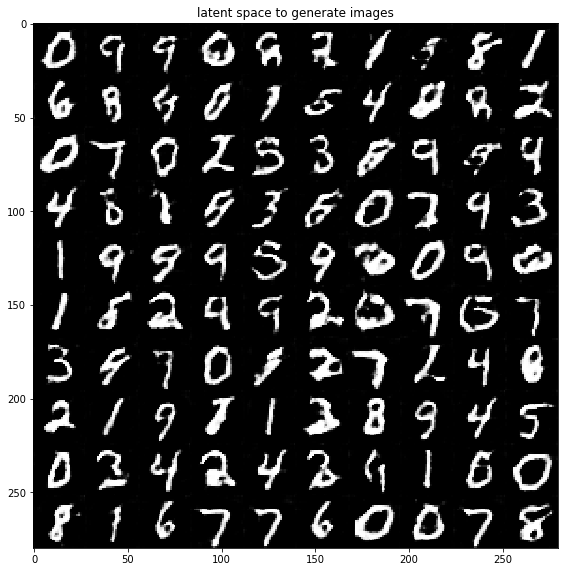

### Epoch 4, Step 0 ###
Current D_loss: 0.047502972185611725, Current G_loss: 1.273656964302063, current_mutual: -3.5598971843719482, current c loss: -3.6074001789093018, curr d loss: 0.047502972185611725



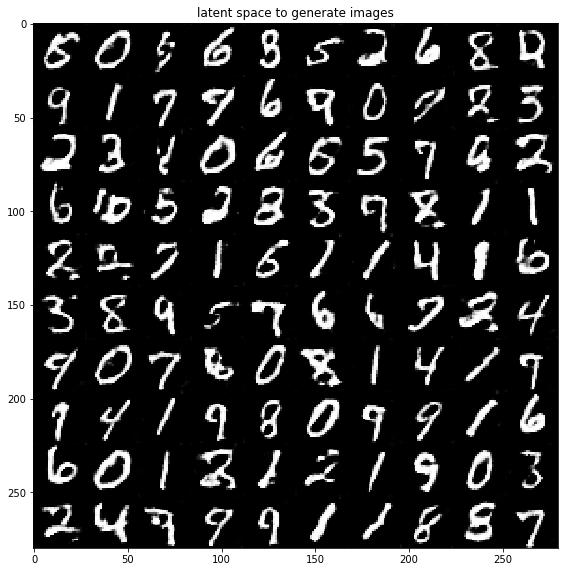

### Epoch 5, Step 0 ###
Current D_loss: 0.08724545687437057, Current G_loss: 1.5120158195495605, current_mutual: -3.369347333908081, current c loss: -3.4565927982330322, curr d loss: 0.08724545687437057



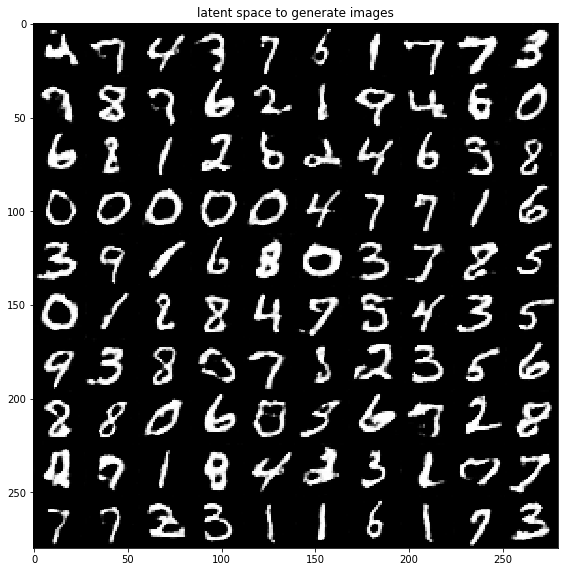

### Epoch 6, Step 0 ###
Current D_loss: 0.0353245884180069, Current G_loss: 1.6061619520187378, current_mutual: -2.6385231018066406, current c loss: -2.6738476753234863, curr d loss: 0.0353245884180069



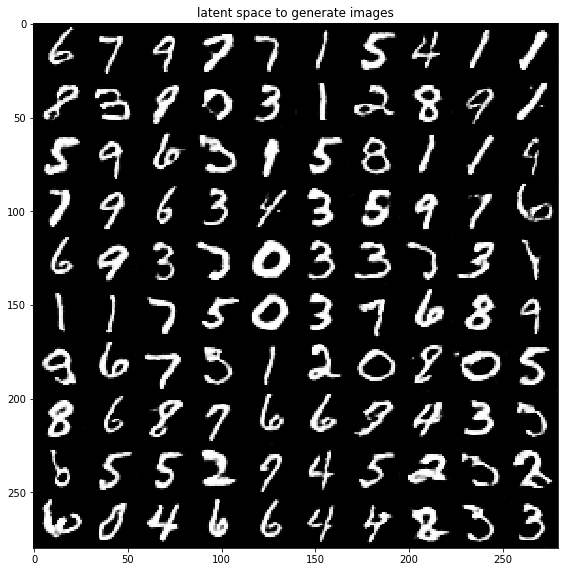

### Epoch 7, Step 0 ###
Current D_loss: 0.03850126266479492, Current G_loss: 1.617287039756775, current_mutual: -4.140154838562012, current c loss: -4.178656101226807, curr d loss: 0.03850126266479492



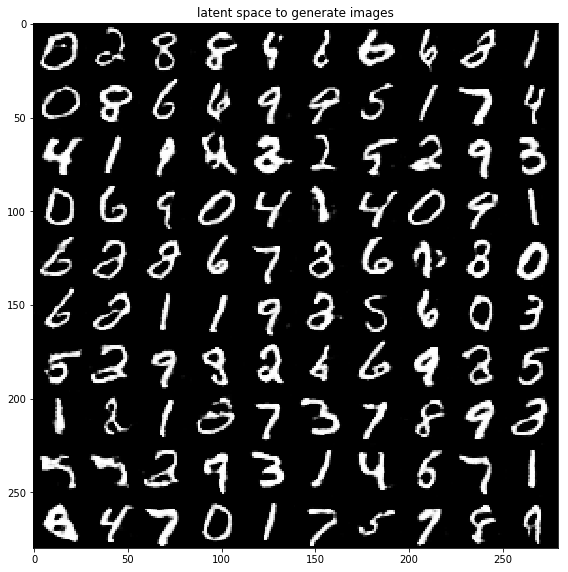

### Epoch 8, Step 0 ###
Current D_loss: 0.09357458353042603, Current G_loss: 1.5743850469589233, current_mutual: -3.9759674072265625, current c loss: -4.069541931152344, curr d loss: 0.09357458353042603



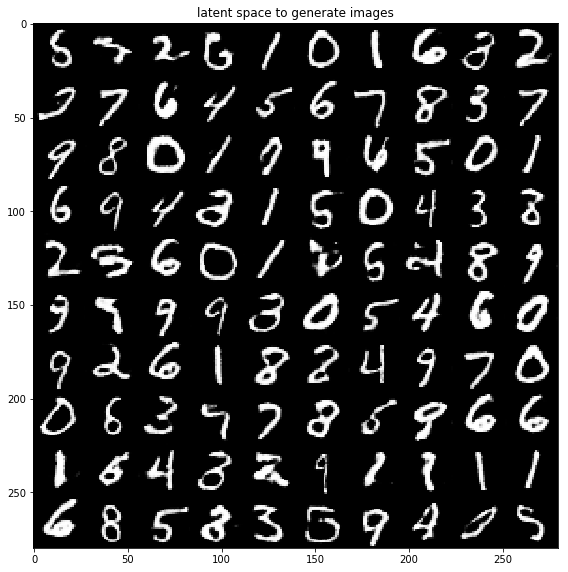

### Epoch 9, Step 0 ###
Current D_loss: 0.033085308969020844, Current G_loss: 1.6692456007003784, current_mutual: -4.057513236999512, current c loss: -4.0905985832214355, curr d loss: 0.033085308969020844



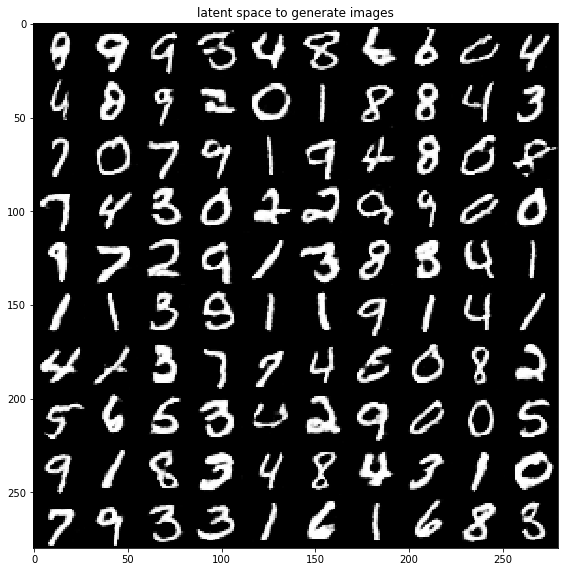

### Epoch 10, Step 0 ###
Current D_loss: 0.06912063807249069, Current G_loss: 1.9731111526489258, current_mutual: -3.558502435684204, current c loss: -3.6276230812072754, curr d loss: 0.06912063807249069



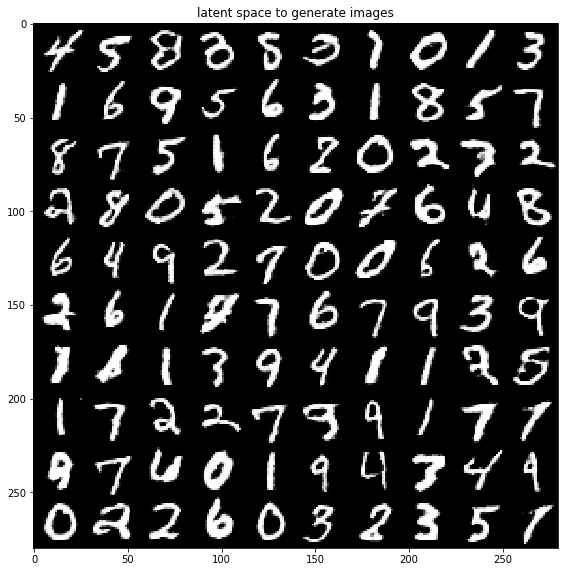

### Epoch 11, Step 0 ###
Current D_loss: 0.012470540590584278, Current G_loss: 1.8835831880569458, current_mutual: -3.8316845893859863, current c loss: -3.8441550731658936, curr d loss: 0.012470540590584278



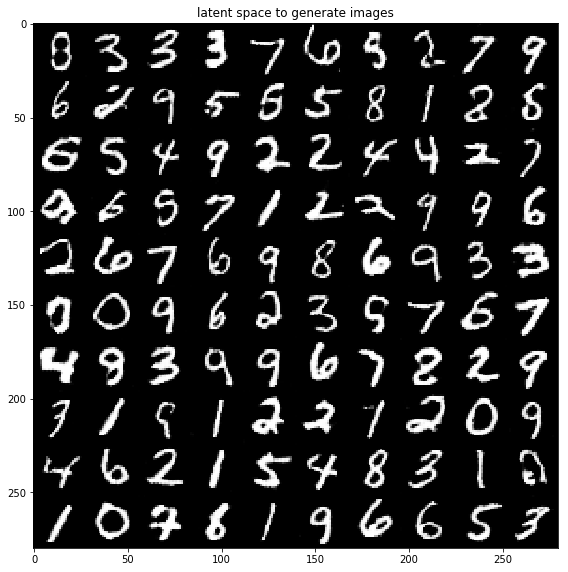

### Epoch 12, Step 0 ###
Current D_loss: 0.015069515444338322, Current G_loss: 1.6690424680709839, current_mutual: -4.268058776855469, current c loss: -4.283128261566162, curr d loss: 0.015069515444338322



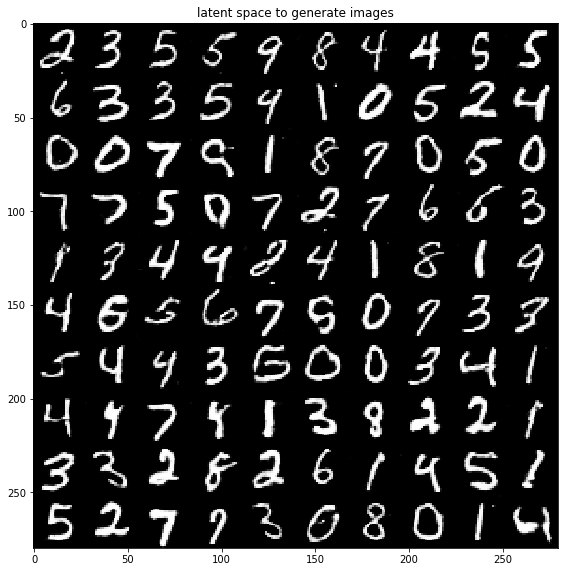

### Epoch 13, Step 0 ###
Current D_loss: 0.020281951874494553, Current G_loss: 2.2498652935028076, current_mutual: -4.43691349029541, current c loss: -4.457195281982422, curr d loss: 0.020281951874494553



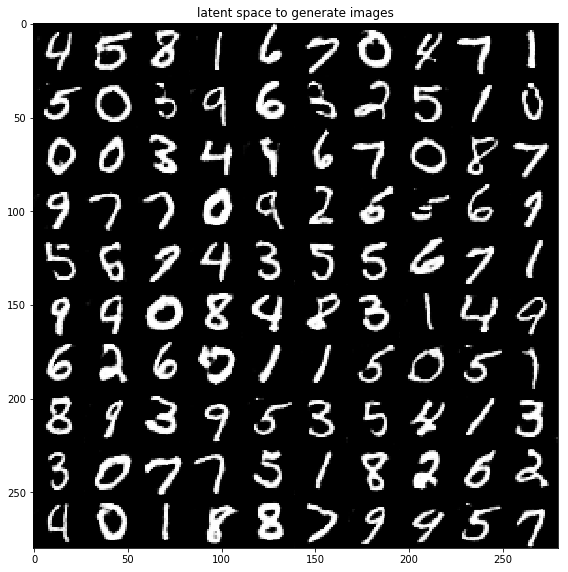

### Epoch 14, Step 0 ###
Current D_loss: 0.008079919032752514, Current G_loss: 1.848626971244812, current_mutual: -3.2348475456237793, current c loss: -3.2429275512695312, curr d loss: 0.008079919032752514



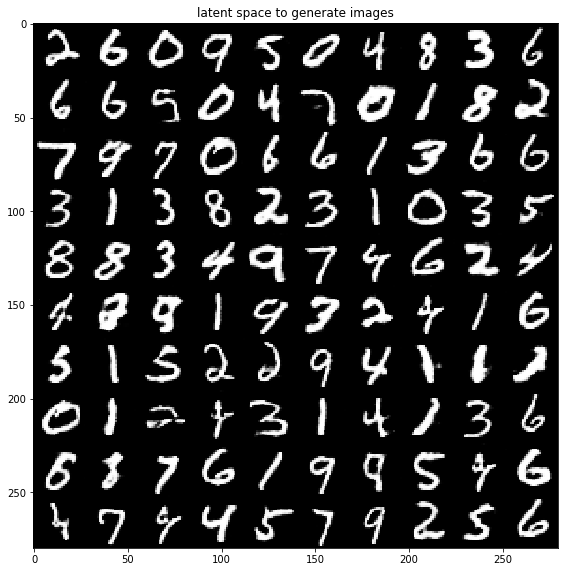

### Epoch 15, Step 0 ###
Current D_loss: 0.004869250580668449, Current G_loss: 1.8991209268569946, current_mutual: -3.5566060543060303, current c loss: -3.5614752769470215, curr d loss: 0.004869250580668449



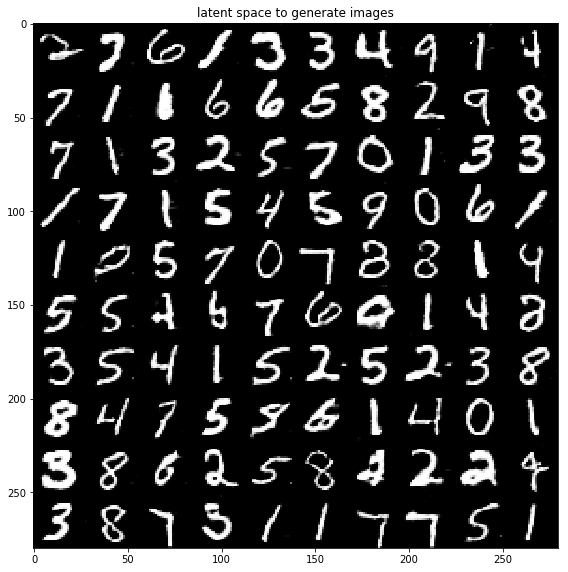

### Epoch 16, Step 0 ###
Current D_loss: 0.013397477567195892, Current G_loss: 2.3769900798797607, current_mutual: -4.0439019203186035, current c loss: -4.057299613952637, curr d loss: 0.013397477567195892



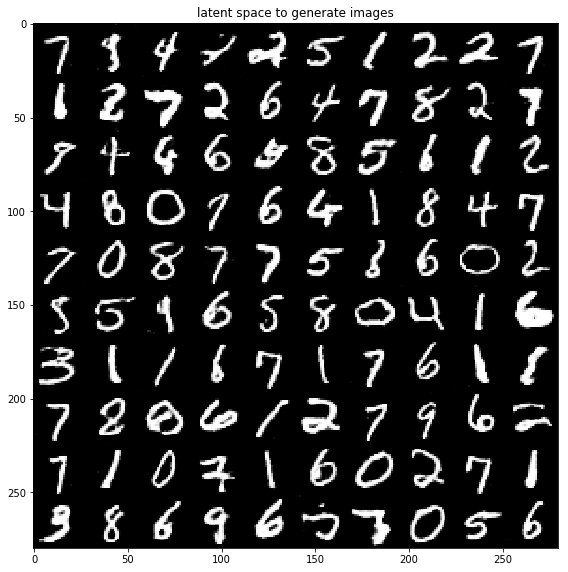

### Epoch 17, Step 0 ###
Current D_loss: 0.010023861192166805, Current G_loss: 2.108875036239624, current_mutual: -4.345849990844727, current c loss: -4.355874061584473, curr d loss: 0.010023861192166805



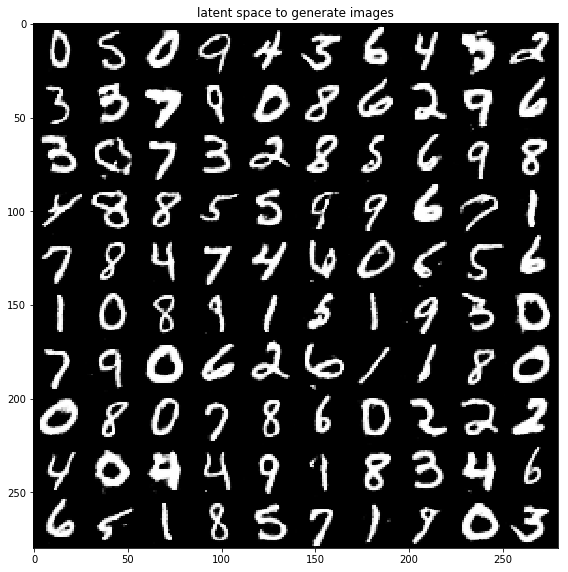

### Epoch 18, Step 0 ###
Current D_loss: 0.0030404650606215, Current G_loss: 1.4585964679718018, current_mutual: -4.577097415924072, current c loss: -4.580137729644775, curr d loss: 0.0030404650606215



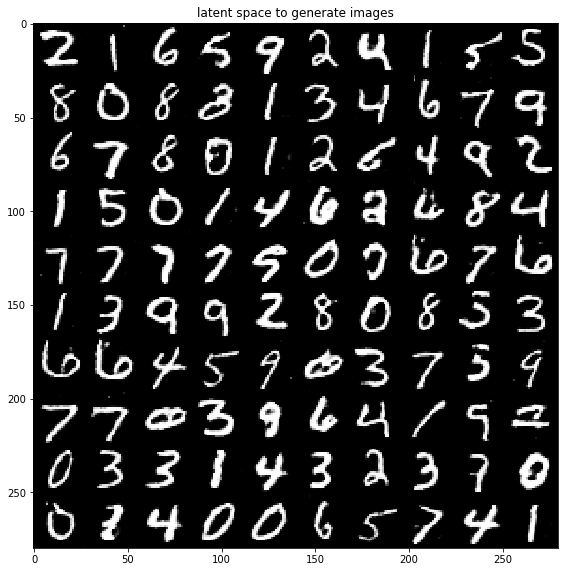

### Epoch 19, Step 0 ###
Current D_loss: 0.0028210782911628485, Current G_loss: 2.3861522674560547, current_mutual: -4.211979389190674, current c loss: -4.2148003578186035, curr d loss: 0.0028210782911628485



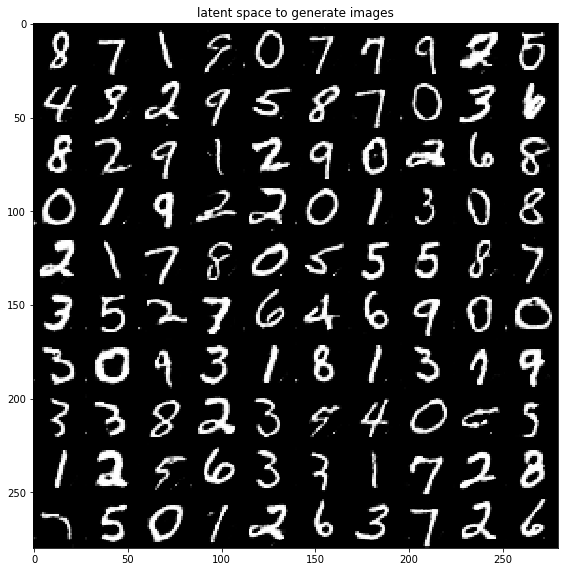

In [8]:
train(train_data,100)

<p style=""></p><p><font size="3"><b>Test the performance of model</b></font></p><p></p>

In [8]:
def inference(path,z=None,c=None,d=None,size=100,reuse=True,name=''):
    if z is None:
        z,_,_=sample(size)
    if c is None:
        _,c,_=sample(size)
    if d is None:
        _,_,d=sample(size)
    m_i=InfoGan()
    g_img=m_i.Generator(reuse=reuse)
    saver=tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess,os.path.join(os.getcwd(),path))
        fake_image=sess.run(g_img,feed_dict={m_i.Z:z,m_i.C:c,m_i.D:d,m_i.is_training_g:False})
        canvas=np.empty((28*10,28*10))
        for xi in range(10):
            for yi in range(10):
                canvas[(xi)*28:(xi+1)*28,yi*28:(yi+1)*28]=fake_image[xi*10+yi].reshape(28,28)
        plt.figure(figsize=(8,10))
        plt.imshow(canvas,origin='upper',cmap='gray')
        plt.title('latent space to generate images '+name)
        plt.tight_layout()  
        plt.show()

In [9]:
d=np.zeros((100,10))
for i in range(10):
    d[i*10:(i+1)*10,i]=1
ct_=np.linspace(-2,2,10)
ct_1=np.zeros((10,10))
ct_1[:]=ct_
ct_1=ct_1.reshape(100,1)
ct_2=np.zeros((100,1))
ct1=np.hstack((ct_1,ct_2))
ct2=np.hstack((ct_2,ct_1))
ct3=np.zeros((100,2))
z=np.zeros((100,62))
dt=np.zeros((100,10))
dt=np.reshape(dt,(10,10,10))
for i in range(10):
    dt[:,i,i]=i
dt=np.reshape(dt,(100,10))

INFO:tensorflow:Restoring parameters from /home/yxu/QINGQING/InfoGan_model/InfoGan_4.ckpt


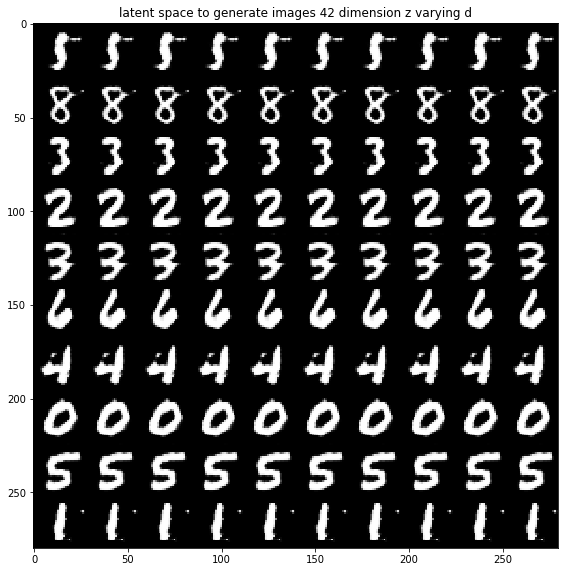

INFO:tensorflow:Restoring parameters from /home/yxu/QINGQING/InfoGan_model/InfoGan_4.ckpt


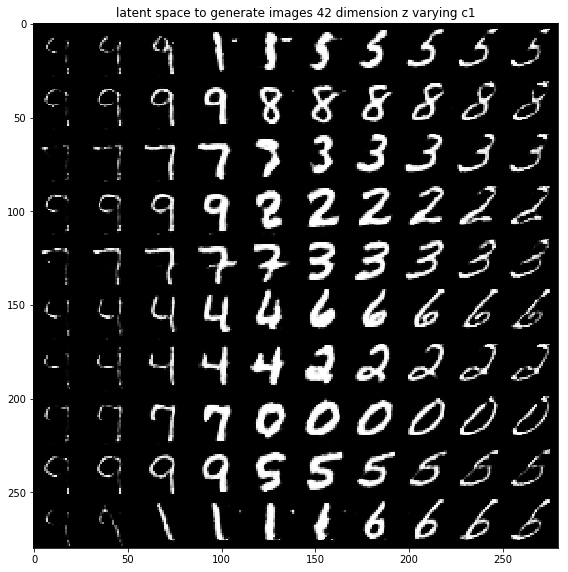

INFO:tensorflow:Restoring parameters from /home/yxu/QINGQING/InfoGan_model/InfoGan_4.ckpt


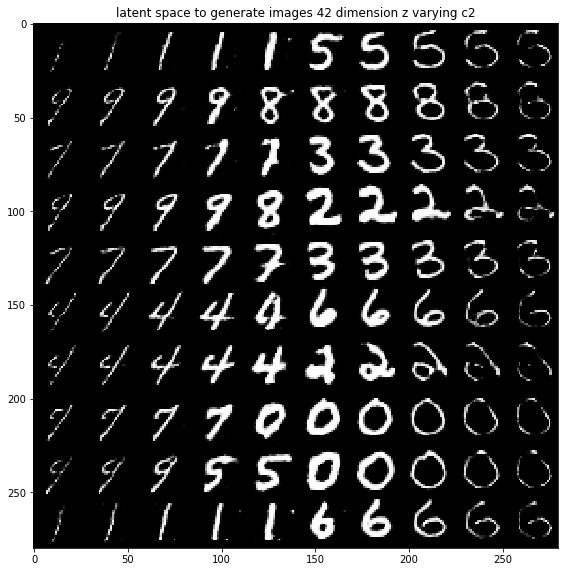

In [10]:
inference('InfoGan_model/InfoGan_4.ckpt',d=d,c=ct3,z=z,name='42 dimension z varying d',reuse=False)
inference('InfoGan_model/InfoGan_4.ckpt',d=d,c=ct1,z=z,name='42 dimension z varying c1',reuse=True)
inference('InfoGan_model/InfoGan_4.ckpt',d=d,c=ct2,z=z,name='42 dimension z varying c2',reuse=True)

In [11]:
newlabel=[7,8,5,6,2,3,0,1,4,9]

In [12]:
def predict(path,x,labels,label_dict,reuse):
    p_i=InfoGan()
    _,y_pre=p_i.Discriminator(p_i.X,reuse=reuse)
    y_hat=tf.argmax(y_pre,1)
    saver=tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess,os.path.join(os.getcwd(),path))
        y_=sess.run(y_hat,{p_i.X:x,p_i.is_training_d:False})  
    y_pred=np.array([label_dict[i] for i in y_])
    label=np.reshape(labels,(-1))
    acc=np.mean(y_pred==label)
    print('### accuracy ###\n',acc)
    return y_pred